# MODELADO UTILIZANDO XGBOOST 

## CON SUB-SAMPLING PARA REDUCIR EL NUMERO DE ROWS

Referencia XGBoost: https://xgboost.readthedocs.io/en/latest/index.html

Referencia sub-sampling: https://www.kdnuggets.com/2019/05/sample-huge-dataset-machine-learning.html

Referencias modelado XGBOOST: 
* https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
* https://xgboost.readthedocs.io/en/latest/parameter.html
* http://theprofessionalspoint.blogspot.com/2019/03/advantages-of-xgboost-algorithm-in.html


Referencia MultiOutput XGBoost: https://stackoverflow.com/questions/39540123/muti-output-regression-in-xgboost

Referencia Limpieza de Memoria: https://stackoverflow.com/questions/1316767/how-can-i-explicitly-free-memory-in-python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
#Ubicamos el dataset
#path = "Z:\MASTER INT. ARTIFICIAL\TFM_DATA\CLEANDATA\\" # Path PC Desktop en casa
#path = "U:\MASTER INT. ARTIFICIAL\TFM_DATA\CLEANDATA\\" # Path Laptop en casa
path = "F:\\DATA_TFM\\CLEANDATA\\" #Path PC Desktop en el trabajo
archivo = "dataset_completo.csv"

In [3]:
#Código que puede servir para generar aleatoriamente los indices
#de las filas a recuperar para el datset, pero no lo aplicare, utilizaré el método sample de dataframe
#ya que este código tiene problemas con el parametro usecols, sin embargo puede servir posteriormente
"""import random
random.seed(10)

n= 63520301 #Líneas en el dataset completo
n1=  100000 #Líneas a obtener para nuestro sampling
skip_list = sorted(random.sample(range(n),(n-n1)))
print(min(skip_list),max(skip_list))
len(skip_list)"""

'import random\nrandom.seed(10)\n\nn= 63520301 #Líneas en el dataset completo\nn1=  100000 #Líneas a obtener para nuestro sampling\nskip_list = sorted(random.sample(range(n),(n-n1)))\nprint(min(skip_list),max(skip_list))\nlen(skip_list)'

In [4]:
#Cargamos el dataset y leemos todo, para despues hacer sumsampling
raw_dataset = pd.read_csv(path+archivo, usecols=['lin_det', 'piso_det', 'mód_opt', 'X\'', 'Y\'', 'Z\'', 'azimut', 'zenit',
                                             'tiempo', 't_selp', 'amp', 'frec_hits', 'aafit_azimut', 'aafit_zenit',
                                             'aafit_lambda', 'aafit_beta', 'bbfit_azimut', 'bbfit_zenit',
                                             'bbfit_quality', 'muon_azimut', 'muon_zenit'])#,nrows=10000)

In [5]:
#Realizamos el subsampling con n líneas
n=10000
rs=10
dataset = raw_dataset.sample(n, random_state=rs)
del raw_dataset #Borramos la anterior lista para liberar memoria
dataset.tail() #Mostramos como quedó el dataset

,lin_det,piso_det,mód_opt,X',Y',Z',azimut,zenit,tiempo,t_selp,...,frec_hits,aafit_azimut,aafit_zenit,aafit_lambda,aafit_beta,bbfit_azimut,bbfit_zenit,bbfit_quality,muon_azimut,muon_zenit
15675186,7,7,2,-35.477413,-15.095539,-83.514434,0.538065,2.356193,1111.213250,1111.213250,...,50.468445,-2.642994,1.581161,-6.514552,0.027619,-2.651094,1.606897,4.106721,-2.844497,1.626004
21153715,2,4,2,76.790921,57.827525,-127.803434,0.693055,2.356193,92.582143,92.582143,...,61.340332,-2.926584,1.357088,-5.881519,0.015498,-9.424778,1.306323,3.240517,-2.638245,1.583089
28343538,8,14,1,11.373284,-38.394692,18.272566,1.627880,2.356193,1112.395753,1059.810683,...,76.045990,0.134690,0.395073,-5.372895,0.007043,0.202409,0.378380,10.799513,0.115643,0.393628
22594244,7,15,0,-35.435291,-15.601902,32.677566,-0.372216,2.356193,1157.436781,1340.446590,...,148.773193,-2.230288,2.568302,-6.122077,0.007134,-2.174362,2.496019,4.713932,-2.167388,2.598427
25642591,4,4,0,44.390199,9.480367,-127.931434,-3.041185,2.356193,1400.076371,971.495534,...,53.329468,-1.216813,1.246325,-5.569547,0.011330,-1.561102,0.666758,16.605148,-1.688086,1.304435


C:\Users\Marco\Anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


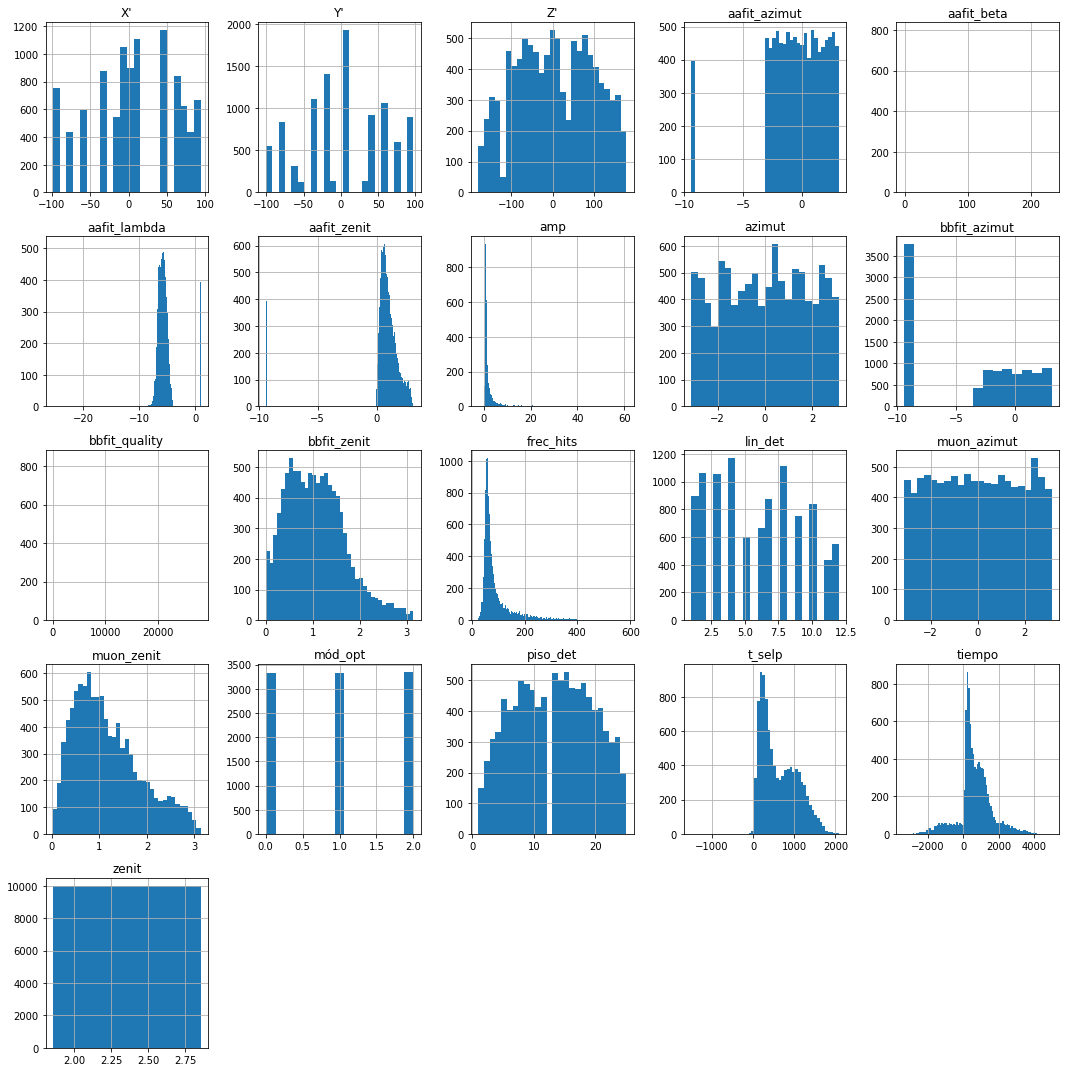

In [365]:
#Graficamos los histogramas de cada variable.
fig = plt.figure(figsize= (15,15))
ax = fig.gca()
dataset.hist(ax=ax,bins='auto')
plt.tight_layout()
plt.show()

In [8]:
### DIVISION DE LA DATA EN TRAIN Y TEST PARA VALIDACIÓN HOLD-OUT INICIAL (VALIDACIÓN ANIDADA AL FINAL)
X = dataset.iloc[:,:19]; Y = dataset.iloc[:,19:21]
#X_values = X.values; Y_values = Y.values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rs)

train_dataset = X_train
test_dataset = X_test
train_labels = Y_train
test_labels = Y_test

In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lin_det,7000.0,5.925286,3.322842e+00,1.000000,3.000000,6.000000,9.000000,12.000000
piso_det,7000.0,13.189286,6.415153e+00,1.000000,8.000000,13.000000,18.000000,25.000000
mód_opt,7000.0,1.008000,8.152315e-01,0.000000,0.000000,1.000000,2.000000,2.000000
X',7000.0,6.934512,5.464288e+01,-98.410729,-35.477413,4.796656,59.522488,93.934807
Y',7000.0,4.056723,5.538685e+01,-101.032169,-38.905038,8.852658,56.583390,97.285109
Z',7000.0,5.143692,9.303604e+01,-180.034434,-69.713892,3.622566,76.341566,177.946108
azimut,7000.0,0.027059,1.792421e+00,-3.119675,-1.549225,0.138309,1.554785,3.128265
zenit,7000.0,2.356193,4.441209e-16,2.356193,2.356193,2.356193,2.356193,2.356193
tiempo,7000.0,643.278220,9.658429e+02,-2950.127817,210.653128,541.000932,1118.670613,4123.794310
t_selp,7000.0,626.042185,4.340713e+02,-1501.918534,253.477331,501.081225,968.122924,2069.723822


In [10]:
train_labels.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
muon_azimut,7000.0,-0.004944,1.807806,-3.138808,-1.564820,-0.025166,1.552623,3.141137
muon_zenit,7000.0,1.168772,0.697160,0.020394,0.623252,1.028794,1.597991,3.131667


In [11]:
test_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lin_det,3000.0,5.958333,3.309116,1.000000,3.000000,6.000000,9.000000,12.000000
piso_det,3000.0,13.052333,6.375511,1.000000,8.000000,13.000000,18.000000,25.000000
mód_opt,3000.0,0.989667,0.819217,0.000000,0.000000,1.000000,2.000000,2.000000
X',3000.0,7.731038,54.289497,-98.406270,-35.471785,4.890204,59.589365,93.934807
Y',3000.0,3.168604,55.586925,-101.015388,-38.994051,8.885169,56.655686,97.285109
Z',3000.0,3.237397,92.459108,-180.034434,-69.716434,3.234566,76.213566,177.946108
azimut,3000.0,-0.002942,1.793004,-3.119675,-1.556330,0.036694,1.523739,3.128265
zenit,3000.0,2.356193,0.000000,2.356193,2.356193,2.356193,2.356193,2.356193
tiempo,3000.0,655.122779,944.978175,-3367.377155,223.626489,563.815039,1136.488242,4988.397927
t_selp,3000.0,638.618048,441.141451,-1227.519849,261.025716,515.303678,981.281740,2084.398824


In [12]:
test_labels.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
muon_azimut,3000.0,0.028143,1.819235,-3.139821,-1.599567,0.040811,1.625311,3.139282
muon_zenit,3000.0,1.183413,0.712636,0.026096,0.621854,1.047900,1.610532,3.096046


## MODELADO XGBOOST PARA CADA VARIABLE POR SEPARADO

<font size=3>Despues de "jugar" un rato con el modelo, me di cuenta que la variable que más afecta es el "learning rate". De hecho se obtienen muy malos resultados en este caso si el valor es menor a 0.1, p.ej. probé con 0.001 y los resultados eran terribles.</font>

In [374]:
#Definimos los modelos para cada variable por separado
from xgboost import XGBRegressor

#Definimos los hiper-parámetros
md = 25; lr= 0.1; na=500; nj=4

xgb_maz = XGBRegressor(max_depth=md, learning_rate=lr, n_estimators=na, verbosity=1, n_jobs=nj, random_state=rs)
xgb_mze = XGBRegressor(max_depth=md, learning_rate=lr, n_estimators=na, verbosity=1, n_jobs=nj, random_state=rs)

In [375]:
# Entrenando los modelos

#Entrenando para muon_azimut
xgb_maz.fit(X_train,Y_train.iloc[:,0], 
            eval_set=[(X_train,Y_train.iloc[:,0]),(X_test,Y_test.iloc[:,0])], eval_metric='mae', verbose=False) 
#Entrenando para muon_zenit
xgb_mze.fit(X_train,Y_train.iloc[:,1], 
            eval_set=[(X_train,Y_train.iloc[:,0]),(X_test,Y_test.iloc[:,0])], eval_metric='mae', verbose=False)

evals_maz = xgb_maz.evals_result()
evals_mze = xgb_mze.evals_result()

#Obteniendo las predicciones
y_pred_maz = xgb_maz.predict(X_test)
y_pred_mze = xgb_mze.predict(X_test)

C:\Users\Marco\Anaconda3\envs\tf_gpu\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Marco\Anaconda3\envs\tf_gpu\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:03:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [376]:
#Comparando algunas (n) predicciones vs valores reales
n=5
templist1 = [y_pred_maz[0:n],y_pred_mze[0:n]]
print("Valores Predichos")
print(pd.DataFrame(templist1).transpose())
print("Valores Reales")
print(Y_test.iloc[0:n].values)

Valores Predichos
          0         1
0  0.263840  0.338458
1 -0.655218  1.318958
2 -1.567995  2.426113
3  0.393020  1.666544
4 -1.981609  1.812686
Valores Reales
[[ 0.23624189  0.36066225]
 [-0.30033259  0.84725319]
 [-0.46081619  2.56209755]
 [ 0.98577492  1.9117797 ]
 [-1.90603035  1.40997404]]


In [377]:
#Obteniendo algunas métricas importantes utilizando las funciones de scikit learn
from sklearn.metrics import mean_absolute_error, max_error, mean_squared_error
import numpy as np

def metricas(y_true,y_predict):
    mae = mean_absolute_error(y_true,y_predict)
    mse = mean_squared_error(y_true,y_predict)
    rmse = np.sqrt(mse)
    maxe= max_error(y_true,y_predict)
    mape = np.mean(np.abs((y_true-y_predict)/y_true)) * 100
    return(mae,mse,rmse,mape,maxe)

mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz = metricas(Y_test.iloc[:,0],y_predict[:,0])
mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze = metricas(Y_test.iloc[:,1],y_predict[:,1])

row_maz = [mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz]
row_mze = [mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze]

data_errors = [row_maz,row_mze]

met_df = pd.DataFrame(data_errors, columns=['MAE','MSE','RMSE','MAPE','MAXE'])

print("\nMétricas de error, 0=Muon_Azimut, 1=Muon_Zenit")
met_df.transpose()


Métricas de error, 0=Muon_Azimut, 1=Muon_Zenit


,0,1
MAE,0.888033,0.174086
MSE,2.059137,0.089725
RMSE,1.434969,0.299542
MAPE,304.255392,23.247488
MAXE,6.096120,2.325296


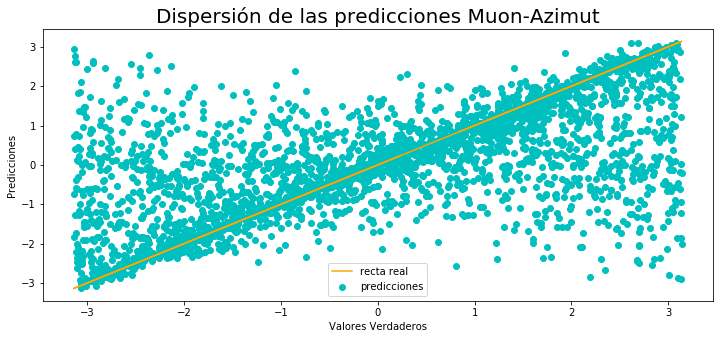

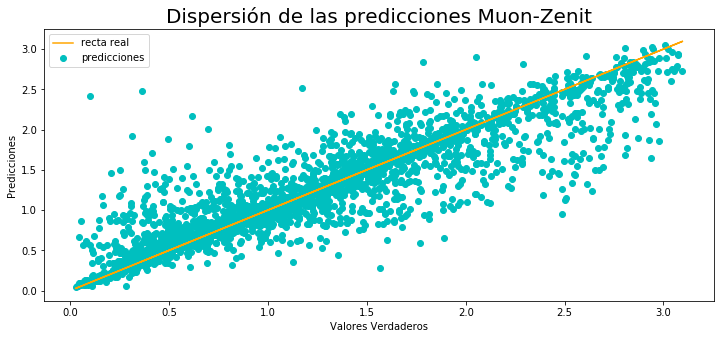

In [386]:
#Graficando la dispersión de las predicciones
plt.figure(figsize=(12,5))
plt.title("Dispersión de las predicciones Muon-Azimut", size=20)
plt.xlabel('Valores Verdaderos')
plt.ylabel('Predicciones')
plt.scatter(Y_test.iloc[:,0],y_pred_maz, c="c",label="predicciones")
_ = plt.plot(Y_test.iloc[:,0],Y_test.iloc[:,0], c="orange", label="recta real")
#_ = plt.plot([-3, 3], [-3, 3],c="orange",label="recta real")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.title("Dispersión de las predicciones Muon-Zenit", size=20)
plt.xlabel('Valores Verdaderos')
plt.ylabel('Predicciones')
plt.scatter(Y_test.iloc[:,1],y_pred_mze, c="c",label="predicciones")
_ = plt.plot(Y_test.iloc[:,1],Y_test.iloc[:,1], c="orange", label="recta real")
#_ = plt.plot([0, 3], [0, 3],c="orange",label="recta real")
plt.legend()
plt.show()

## MODELADO XGBOOST UTILIZANDO MULTIOUTPUT REGRESSOR

<font size=3>Usar el MultiOutput nos permite generar un modelo para mas de 1 variable de salida, sin necesidad de generar dos como en las celdas anteriores  y tal como es nuestro caso.</font>

Referencias:

* https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html
* https://stats.stackexchange.com/questions/153853/regression-with-scikit-learn-with-multiple-outputs-svr-or-gbm-possible

In [387]:
#Construimos un modelo XGBoost usando un MultiOutput Regressor (para predecir ambas variables azimut y zenit)
from sklearn.multioutput import MultiOutputRegressor

#Definimos los hiper-parámetros
md = 25; lr= 0.1; na=500; nj=4

#md = 20; lr= 0.1; na=100; nj=4

xgb = XGBRegressor(max_depth=md, learning_rate=lr, n_estimators=na, verbosity=1, n_jobs=nj, random_state=rs)
regmodel = MultiOutputRegressor(xgb)
regmodel.fit(X_train,Y_train)

[20:08:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=25, min_child_weight=1,
                                            missing=None, n_estimators=500,
                                            n_jobs=4, nthread=None,
                                            objective='reg:linear',
                                            random_state=10, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verb

In [388]:
# Generando las predicciones
y_predict = regmodel.predict(X_test)

In [389]:
#Comparando algunas predicciones vs valores reales
templist1 = []
print("Valores Predichos")
print(y_predict[0:5])
#print(pd.DataFrame(templist1).transpose())
print("Valores Reales")
print(Y_test.iloc[0:5].values)

Valores Predichos
[[ 0.26384008  0.33845806]
 [-0.6552185   1.3189584 ]
 [-1.5679948   2.4261131 ]
 [ 0.39301997  1.6665441 ]
 [-1.9816089   1.8126862 ]]
Valores Reales
[[ 0.23624189  0.36066225]
 [-0.30033259  0.84725319]
 [-0.46081619  2.56209755]
 [ 0.98577492  1.9117797 ]
 [-1.90603035  1.40997404]]


In [390]:
#Obteniendo algunas métricas importantes utilizando las funciones de scikit learn
mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz = metricas(Y_test.iloc[:,0],y_predict[:,0])
mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze = metricas(Y_test.iloc[:,1],y_predict[:,1])

row_maz = [mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz]
row_mze = [mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze]

data_errors = [row_maz,row_mze]

met_df = pd.DataFrame(data_errors, columns=['MAE','MSE','RMSE','MAPE','MAXE'])

print("\nMétricas de error, 0=Muon_Azimut, 1=Muon_Zenit")
met_df.transpose()


Métricas de error, 0=Muon_Azimut, 1=Muon_Zenit


,0,1
MAE,0.888033,0.174086
MSE,2.059137,0.089725
RMSE,1.434969,0.299542
MAPE,304.255392,23.247488
MAXE,6.096120,2.325296


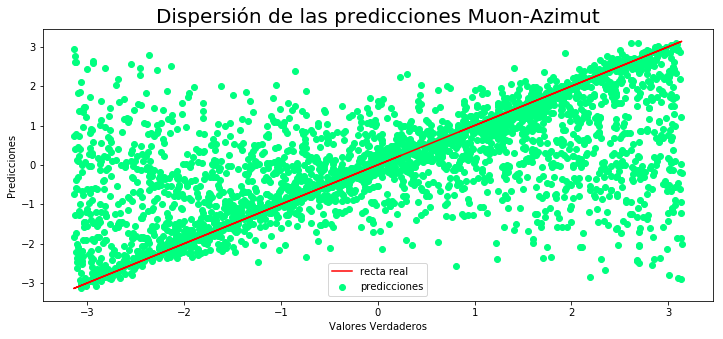

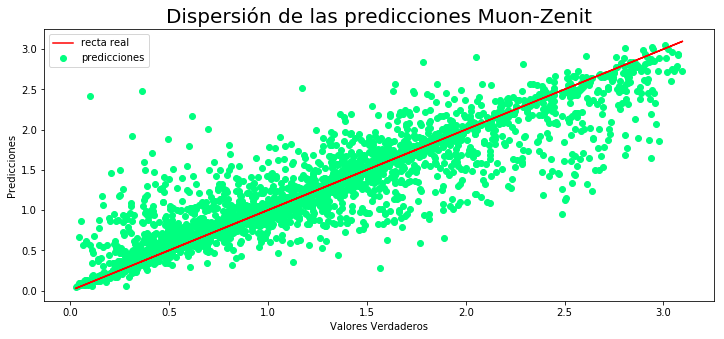

In [394]:
#Graficando la dispersión de las predicciones
plt.figure(figsize=(12,5))
plt.title("Dispersión de las predicciones Muon-Azimut", size=20)
plt.xlabel('Valores Verdaderos')
plt.ylabel('Predicciones')
plt.scatter(Y_test.iloc[:,0],y_predict[:,0], c="springgreen",label="predicciones")
_ = plt.plot(Y_test.iloc[:,0],Y_test.iloc[:,0], c="red", label="recta real")
#_ = plt.plot([-3, 3], [-3, 3],c="red",label="recta real")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.title("Dispersión de las predicciones Muon-Zenit", size=20)
plt.xlabel('Valores Verdaderos')
plt.ylabel('Predicciones')
plt.scatter(Y_test.iloc[:,1],y_predict[:,1], c="springgreen",label="predicciones")
_ = plt.plot(Y_test.iloc[:,1],Y_test.iloc[:,1], c="red", label="recta real")
#_ = plt.plot([0, 3], [0, 3],c="red",label="recta real")
plt.legend()
plt.show()

# ANALISIS Y CONCLUSIONES DEL MODELADO XGBOOST

<font size=3>
    
<B>Análisis y Ajuste de Hiper-parámetros</B>

Para poder hacer el problema más manejable desde un punto de vista de poder de cómputo limitado, se decidió hacer subsampling, y dado que esto podría traer problemas de subrepresentación estadística en las variables de entrada o de salida, se utilizaron las gráficas de los histogramas para verificar de manera visual y empírica su distribución. 

Se llevaron a cabo diversos experimentos utilizando valores distintos para los hiper parámetros, con lo que se aprendió que para este dataset en específico, el hiper parámetro que más afectaba al resultado es el de learning rate, adicionalmente se hicieron pruebas con la profundidad del arbol (max depth), llendo desde 5 hasta 100, así como también se experimento variando el número de árboles desde 10 hasta 1000. Estas pruebas no se muestran aquí, sin embargo se vió que los parámetros que se muestran como finales en este NoteBook son los que mejores resultados arrojan.

<B>Conclusión</B>

Como se puede apreciar, el utilizar XGBoost es extremadamente eficaz en tiempo, ya que el algoritmo calcula muy rápido debido a que permite utilizar procesamiento paralelo, sin embargo es muy malo el resultado  y en algunos casos no es en absoluto eficaz, como se puede ver en las gráficas de dispersión, así como también se puede apreciar de los resultados de las métricas.

De las gráficas podemos observar que para la variable muon_azimut, las predicciones no son para nada buenas, sin embargo para la variable muon_zenit, son "aceptables".
    
Dado lo anterior, se puede concluir que no es un buen algoritmo para utilizar en este problema en específico y debemos tratar de encontrar otro que mejore los resultados para la variable muon_azimut.

## Fecha: 2 de Agosto de 2019